In [73]:
import os
import sys
from datetime import datetime, timedelta
import logging
import pickle
import time
from dataclasses import dataclass, field
from enum import Enum
from typing import Any, Dict, List, Optional, Set, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import unicodedata
from dotenv import load_dotenv

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify sys.path
# print("Current sys.path:", sys.path)

from src.data_processing.nst_scraper import nst_on_ice_scraper, nst_team_on_ice_scraper
from src.db.nhl_db_utils import update_player_db, check_last_update, get_player_full_name, insert_player_data
from src.db.the_odds_db_utils import get_team_moneyline_odds
from src.data_processing.team_utils import get_most_recent_game_id, get_fullname_by_tricode
from src.data_processing.game_utils import get_game_boxscore, display_boxscore
from src.data_processing.pbp_utils import get_matchup_games
from src.data_processing.player_utils import fetch_player_data

from src.entities.lineup import Lineup, Player, Position

from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
np.set_printoptions(legacy='1.25')

In [74]:
today_datetime= datetime.now()
yesterday_datetime = today_datetime - timedelta(days=1, hours=6) # UTC offset
yesterday = yesterday_datetime.strftime('%Y-%m-%d')
yesterday

'2025-01-24'

In [75]:
# Load environment variables from .env file
load_dotenv()

db_prefix = 'NHL_DB_'

In [76]:
# Check the last update time of the players database
last_update = check_last_update(db_prefix)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Last database update was on: 2025-01-24
INFO:src.db.base_utils:Database connection closed.


In [77]:
# Convert last_update to datetime
last_update_dt = datetime.strptime(last_update, '%Y-%m-%d')
today_dt = datetime.strptime(today_datetime.strftime('%Y-%m-%d'), '%Y-%m-%d')
yesterday_dt = datetime.strptime(yesterday, '%Y-%m-%d')

# Only update if last update was before yesterday
if last_update_dt not in [today_dt, yesterday_dt]:
    # Update the player database from last update to yesterday
    update_player_db(last_update, yesterday, db_prefix, skip_existing=True)
else:
    print(f"No need to update the player database. Last update was on: {last_update}")


No need to update the player database. Last update was on: 2025-01-24


In [78]:
def get_skater_stats(lineup: Lineup, player_stats_df: pd.DataFrame, filter: Optional[str] = None) -> pd.DataFrame:
    """
    Gets stats for players in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing players
        player_stats_df (pd.DataFrame): DataFrame with player statistics
        filter (str, optional): Type of filter to apply on the stats.
        Defaults to None, which keeps all stats. If 'shots', only shot-related statistics are kept.
        
    Returns:
        pd.DataFrame: Player statistics ordered according to lineup positions
    """
    # Apply filter if specified
    if filter == 'shots':
        # Define shot-related columns to keep
        shot_columns = ['player', 'team', 'position', 'gp', 'toi', 'toi/gp','shots/60', 'icf/60', 'iff/60'] 
        player_stats_df = player_stats_df[shot_columns]
    
    # Create ordered list of players (forwards then defense)
    players = []
    # Add forwards in order
    players.extend([p for p in lineup.forwards if p])
    # Add defense in order 
    players.extend([p for p in lineup.defense if p])
    
    # Create ordered list of player names
    player_names = [player.name for player in players]
    
    # Filter stats and reorder to match lineup order
    stats_df = player_stats_df[player_stats_df['player'].isin(player_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(player_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    stats_df = stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)
    
    # Add 'b2b' column to the right of 'position'
    stats_df.insert(stats_df.columns.get_loc('position') + 1, 'b2b', lineup.back_to_back)
    
    return stats_df

In [79]:
def get_goalie_stats(lineup: Lineup, goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing goalies
        goalie_stats_df (pd.DataFrame): DataFrame with goalie statistics
        
    Returns:
        pd.DataFrame: Goalie statistics ordered according to lineup positions
    """
    # Create ordered list of goalies
    goalies = [goalie for goalie in lineup.goalies if goalie]
    goalie_names = [goalie.name for goalie in goalies]
    
    # Filter stats and reorder to match lineup order
    stats_df = goalie_stats_df[goalie_stats_df['player'].isin(goalie_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(goalie_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

In [80]:
def extract_team_lineup(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.
    
    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.
    
    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id, back_to_back = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbreviations to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    elif team.upper() == 'UTA':
        # Since UTA did not exist in the previous season, match with ARI
        if 'ARI' == away_team_code.upper():
            team_side = 'Away'
            skaters = away_skaters
            goalies = away_goalies
        elif 'ARI' == home_team_code.upper():
            team_side = 'Home'
            skaters = home_skaters
            goalies = home_goalies
        else:
            raise ValueError(f"Team '{team}' not found in game ID {game_id}.")
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")
    print(f"Back to back: {back_to_back}")
    lineup.back_to_back = back_to_back  # Assign back_to_back to the Lineup

    # Add Skaters to the Lineup
    for _, skater in skaters.iterrows():
        try:
            position_enum = Position(skater['position'])  # Convert to Position Enum
        except ValueError:
            print(f"Invalid position '{skater['position']}' for player '{skater['name']}'. Skipping.")
            continue
        
        name = get_player_full_name(skater['playerId'], db_prefix, suppress_log=True)
        # If player's name is None, fetch the player's information and store it
        if name is None:
            player_data = fetch_player_data(skater['playerId'])
            if player_data:
                insert_player_data(player_data, 'NHL_DB_')
            name = get_player_full_name(skater['playerId'], db_prefix, suppress_log=True)
        
        player = Player(
            player_id=skater['playerId'],
            name=name,
            team=team.upper(),
            position=position_enum
        )

        # Add player to the appropriate category in the lineup
        if player.position.category == 'F':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
                lineup.add_forward(player, empty_slot)
            except StopIteration:
                # Attempt to add a new forward slot
                try:
                    lineup.adjust_slots('forwards', delta=1)
                    empty_slot = len(lineup.forwards) - 1
                    lineup.add_forward(player, empty_slot)
                    print(f"Added a new forward slot. Total forwards: {len(lineup.forwards)}.")
                except ValueError as e:
                    print(f"Cannot adjust forward slots: {e}. Skipping player '{player.name}'.")
        elif player.position.category == 'D':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.defense) if p is None)
                lineup.add_defense(player, empty_slot)
            except StopIteration:
                # Attempt to add a new defense slot
                try:
                    lineup.adjust_slots('defense', delta=1)
                    empty_slot = len(lineup.defense) - 1
                    lineup.add_defense(player, empty_slot)
                    print(f"Added a new defense slot. Total defensemen: {len(lineup.defense)}.")
                except ValueError as e:
                    print(f"Cannot adjust defense slots: {e}. Skipping player '{player.name}'.")
        else:
            print(f"Player '{player.name}' has an unrecognized category '{player.position.category}'. Skipping.")

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
chicago_lineup = extract_team_lineup('CHI', '2024-11-21')

Game ID: 2024020298
Back to back: 0
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Craig Smith' to Forwards slot 2.
Added player 'Jason Dickinson' to Forwards slot 3.
Added player 'Nick Foligno' to Forwards slot 4.
Added player 'Joey Anderson' to Forwards slot 5.
Added player 'Philipp Kurashev' to Forwards slot 6.
Added player 'Tyler Bertuzzi' to Forwards slot 7.
Added player 'Taylor Hall' to Forwards slot 8.
Added player 'Lukas Reichel' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Alec Martinez' to Defense slot 2.
Added player 'Nolan Allan' to Defense slot 3.
Added player 'Wyatt Kaiser' to Defense slot 4.
Added player 'Alex Vlasic' to Defense slot 5.
Added player 'TJ Brodie' to Defense slot 6.
Added player 'Drew Commesso' to Goalies slot 1.
Added player 'Arvid Soderblom' to Goalies sl

In [81]:
def calculate_min_percentage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average time on ice per game as a percentage of total game time (60 minutes).
    
    Args:
        df (pd.DataFrame): DataFrame containing 'toi' and 'gp' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'min%' column added
    """
    df_copy = df.copy()
    df_copy['min%'] = (df_copy['toi'] / df_copy['gp'] / 300 * 100).round(2)
    return df_copy

# # Apply the function to lineup_player_stats
# lineup_player_stats = calculate_min_percentage(lineup_player_stats)
# lineup_player_stats

def sum_min_percentage(df: pd.DataFrame) -> float:
    """
    Calculates the sum of the 'min%' column in the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        
    Returns:
        float: The total sum of the 'min%' values.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    total_min_percentage = df['min%'].sum()
    return total_min_percentage

# Example usage:
# total_min_percentage = sum_min_percentage(lineup_player_stats)
# print(f"Total min%: {total_min_percentage}")

def calculate_adj_min(df: pd.DataFrame, total_min_percentage: float) -> None:
    """
    Calculates the adjusted minimum (adj_min) for each player based on their min% and the total min%.
    
    The formula used is:
        adj_min = (min% / total_min_percentage) * 300
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        total_min_percentage (float): The total sum of the 'min%' column.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
        ValueError: If total_min_percentage is not a positive number.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    if total_min_percentage <= 0:
        raise ValueError("total_min_percentage must be a positive number.")
    
    # Calculate and append the 'adj_min' column
    df['adj_min'] = ((df['min%'] / total_min_percentage) * 300).round(2)

# # Example usage:
# calculate_adj_min(lineup_player_stats, total_min_percentage)
# print(lineup_player_stats[['player', 'min%', 'adj_min']])

In [82]:
# Define file paths to load the model and transformer
model_filepath = '../models/polynomial_model_degree_1.pkl'
poly_filepath = '../models/polynomial_features_degree_1.pkl'

# Load the regression model
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print(f"Model loaded from {model_filepath}")

# Load the PolynomialFeatures transformer
with open(poly_filepath, 'rb') as poly_file:
    loaded_poly = pickle.load(poly_file)
print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

# Function to make predictions using the loaded model and transformer
def predict_gpm(new_ixg60_value, model, poly, x_col='ixg60'):
    """
    Predicts 'gpm' using the loaded model and polynomial transformer.
    
    Parameters:
        new_ixg60_value (float): The new ixg60 value for prediction.
        model (RegressionResults): The loaded regression model.
        poly (PolynomialFeatures): The loaded polynomial features transformer.
        x_col (str): The name of the independent variable column. Defaults to 'ixg60'.
        
    Returns:
        predicted_gpm (float): The predicted gpm value.
    """
    # Prepare the input data
    X_new = np.array([[new_ixg60_value]])
    X_new_poly = poly.transform(X_new)
    X_new_poly_const = sm.add_constant(X_new_poly, has_constant='add')
    
    # Create DataFrame with appropriate column names
    feature_names = ['const'] + poly.get_feature_names_out([x_col]).tolist()
    new_data = pd.DataFrame(X_new_poly_const, columns=feature_names)
    
    # Predict
    predicted_gpm = model.predict(new_data)
    return predicted_gpm.iloc[0]

# Example: Predicting 'gpm' for a new ixg60 value
# new_ixg60_value = 50
# predicted_gpm = predict_gpm(new_ixg60_value, loaded_model, loaded_poly)
# print(f"Predicted GPM for ixg60={new_ixg60_value}: {predicted_gpm:.4f}")

Model loaded from ../models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from ../models/polynomial_features_degree_1.pkl


In [83]:
# Function to predict GPM for each player and add it to the DataFrame
def add_gpm_to_lineup(lineup_df, model, poly):
    """
    Adds a 'gpm' column to the lineup_player_stats DataFrame using the predict_gpm function.
    
    Args:
        lineup_df (pd.DataFrame): DataFrame containing 'ixg/60' column.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with 'gpm' column added.
    """
    # Define a helper function to handle potential missing or invalid values
    def safe_predict(ixg_60):
        if pd.isna(ixg_60):
            return np.nan
        try:
            return predict_gpm(ixg_60, model, poly)
        except Exception as e:
            print(f"Error predicting GPM for ixg_60={ixg_60}: {e}")
            return np.nan
    
    # Apply the predict_gpm function to each 'ixg/60' value
    lineup_df['gpm'] = lineup_df['ixg/60'].apply(safe_predict)
    return lineup_df

# # Apply the function to add 'gpm' to your DataFrame
# lineup_player_stats = add_gpm_to_lineup(lineup_player_stats, loaded_model, loaded_poly)

# # Display the updated DataFrame with 'gpm'
# print(lineup_player_stats[['player', 'ixg/60', 'gpm']])

In [84]:
def calculate_x_goals(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_goals' by multiplying 'gpm' with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'gpm' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'gpm' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'gpm' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'gpm', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'gpm' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['gpm']):
        raise TypeError("'gpm' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_goals'
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_goals'] = lineup_stats_df['gpm'] * lineup_stats_df['adj_min']
    
    return lineup_stats_df

In [85]:
def calculate_league_avg_xg_against_per_60(goalie_stats_df: pd.DataFrame) -> float:
    """
    Calculate the league average expected goals against (xg_against) per 60 minutes.

    Args:
        goalie_stats_df (pd.DataFrame): DataFrame containing goalie statistics with 'xg_against' and 'toi' columns.

    Returns:
        float: The league average xg_against per 60 minutes.

    Raises:
        KeyError: If required columns are missing from the DataFrame.
        ValueError: If no valid goalies with non-zero 'toi' are found.
    """
    # Ensure required columns are present
    required_columns = {'xg_against', 'toi'}
    missing_columns = required_columns - set(goalie_stats_df.columns)
    if missing_columns:
        raise KeyError(f"Missing columns in goalie_stats_df: {', '.join(missing_columns)}")

    # Drop rows with missing or zero 'toi' to avoid division errors
    valid_goalies = goalie_stats_df.dropna(subset=['xg_against', 'toi'])
    valid_goalies = valid_goalies[valid_goalies['toi'] > 0]

    if valid_goalies.empty:
        raise ValueError("No valid goalies with non-zero 'toi' found in goalie_stats_df.")

    # Calculate xg against per 60 minutes for each goalie
    valid_goalies['xg_against_per_60'] = (valid_goalies['xg_against'] / valid_goalies['toi']) * 60

    # Calculate the league average
    league_avg_xg_against_per_60 = valid_goalies['xg_against_per_60'].mean()

    return league_avg_xg_against_per_60

In [86]:
def calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60):
    """
    Calculate the expected goals against adjusted percentage.
    """
    lineup_goalie_stats['adj%'] = (lineup_goalie_stats['xg_against/60'] / goalie_avg_xg_against_per_60) * 100
    return lineup_goalie_stats

In [87]:
def predict_lineup_xgoals(input_date: str, team: str, model, poly, last_n: int = None, player_stats_df: pd.DataFrame=None, goalie_stats_df: pd.DataFrame=None) -> pd.DataFrame:
    """
    Predicts expected goals (xgoals) for a team's lineup using player metrics and regression model.
    Processes the team's lineup for a given date and predicts GPM for each player.
    This function performs the following steps:
        1. Calls `nst_on_ice_scraper` for the input date minus one day.
        2. Extracts the team's lineup using `extract_team_lineup`.
        3. Retrieves skater statistics with `get_skater_stats`.
        4. Calculates `min%` using `calculate_min_percentage`.
        5. Computes `adj_min` using `calculate_adj_min`.
        6. Determines `ixg_per_60` using `calculate_ixg_per_60`.
        7. Predicts `gpm` using the loaded polynomial regression model.
        8. Calculcates x_goals by multiplying gpm by adj_min    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and predicted GPM.
    
    Raises:
        ValueError: If any step in the data processing pipeline fails.
    """

    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If player_stats_df is not provided, fetch them
        if player_stats_df is None or player_stats_df.empty:
            player_stats_df = nst_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                last_n=last_n,
                rate='y'
            )
            print("Player and goalie statistics fetched successfully.")
        else:
            print("Player and goalie statistics already provided.")

        if goalie_stats_df is None or goalie_stats_df.empty:
            goalie_stats_df = nst_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                pos='G',
                rate='y',
                stdoi='g',
                last_n=last_n
            )
            print("Goalie statistics fetched successfully.")
        else:
            print("Goalie statistics already provided.")

        # Step 3: Extract team lineup for the input date and team
        lineup = extract_team_lineup(team, input_date)
        print(f"Lineup extracted for team {team} on {input_date}.")

        # Step 4: Get skater statistics for the lineup
        lineup_skater_stats = get_skater_stats(lineup, player_stats_df)

        # Step 5: Calculate min%
        lineup_skater_stats = calculate_min_percentage(lineup_skater_stats)

        # Step 6: Calculate adj_min
        total_min_percentage = sum_min_percentage(lineup_skater_stats)
        calculate_adj_min(lineup_skater_stats, total_min_percentage)

        # Step 7: Predict gpm using the polynomial regression model
        lineup_skater_stats = add_gpm_to_lineup(lineup_skater_stats, model, poly)

        # Step 8: Calculate x_goals
        lineup_skater_stats = calculate_x_goals(lineup_skater_stats)

        # Step 9: Get goalie stats for the lineup
        lineup_goalie_stats = get_goalie_stats(lineup, goalie_stats_df)
        
        # Step 10: Calculate league average xg_against_per_60
        goalie_avg_xg_against_per_60 = goalie_stats_df['xg_against/60'].mean()

        lineup_goalie_stats = calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60)
        
        return lineup_skater_stats, lineup_goalie_stats

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# lineup = predict_lineup_xgoals('2025-01-24', 'WPG', loaded_model, loaded_poly)
# lineup

In [88]:
# import glob
# csv_files = glob.glob('*2025-01-24.csv')
# df_list = [pd.read_csv(file) for file in csv_files]
# combined_df = pd.concat(df_list, ignore_index=True)
# combined_df.to_csv('combined_2025-01-24.csv', index=False)

In [89]:
def load_models(model_filepath='../models/polynomial_model_degree_1.pkl',
               poly_filepath='../models/polynomial_features_degree_1.pkl'):
    """
    Loads the regression model and PolynomialFeatures transformer from the specified file paths.

    Args:
        model_filepath (str): Path to the saved regression model pickle file.
        poly_filepath (str): Path to the saved PolynomialFeatures transformer pickle file.

    Returns:
        tuple: A tuple containing the loaded regression model and PolynomialFeatures transformer.

    Raises:
        FileNotFoundError: If either of the specified files does not exist.
        pickle.UnpicklingError: If there is an error unpickling the files.
    """
    try:
        # Load the regression model
        with open(model_filepath, 'rb') as model_file:
            loaded_model = pickle.load(model_file)
        print(f"Model loaded from {model_filepath}")

        # Load the PolynomialFeatures transformer
        with open(poly_filepath, 'rb') as poly_file:
            loaded_poly = pickle.load(poly_file)
        print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

        return loaded_model, loaded_poly

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
        raise
    except pickle.UnpicklingError as pickle_error:
        print(f"Error loading pickle files: {pickle_error}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

# Example usage
# Load the models using the new function
# loaded_model, loaded_poly = load_models()

# # Call the function with desired date and team
# input_date = '2024-12-02'
# team = 'TOR'
# lineup_skater_stats, lineup_goalie_stats = predict_lineup_xgoals(input_date, team, loaded_model, loaded_poly)

In [90]:
def calculate_predicted_goals(matchups_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate predicted goals by multiplying x_goals with opposing team's goalie adjustment percentage.
    
    Args:
        matchups_df: DataFrame containing x_goals and adj% columns from process_matchups_for_date
        
    Returns:
        DataFrame with added predicted goals columns
    """
    # Convert percentages to multipliers (e.g. 105% -> 1.05)
    matchups_df = matchups_df.copy()
    matchups_df['away_adj%'] = matchups_df['away_adj%'] / 100
    matchups_df['home_adj%'] = matchups_df['home_adj%'] / 100
    
    # Calculate predicted goals
    matchups_df['away_pred_goals'] = matchups_df['away_x_goals'] * matchups_df['home_adj%']
    matchups_df['home_pred_goals'] = matchups_df['home_x_goals'] * matchups_df['away_adj%']
    
    return matchups_df

In [91]:
def calculate_win_probabilities(matchups_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate home and away win probabilities based on predicted goals.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_pred_goals' and 'away_pred_goals'.
    
    Returns:
        pd.DataFrame: DataFrame with added 'home_win_prob' and 'away_win_prob' columns, and selected columns.
    """
    HIA = 0.28 # home ice advantage
    HOME = matchups_df['home_pred_goals']
    AWAY = matchups_df['away_pred_goals']
    
    matchups_df['home_win_prob'] = 1 / (1 + np.exp((-(HIA + HOME - AWAY) / 1.318)))
    matchups_df['away_win_prob'] = 1 - matchups_df['home_win_prob']
    
    return matchups_df[[
        'date', 'game_id', 'away_team', 'home_team', 'away_b2b', 'home_b2b',
        'away_x_goals', 'away_adj%', 'home_x_goals', 'home_adj%', 
        'away_pred_goals', 'home_pred_goals',
        'away_win_prob', 'home_win_prob'
    ]]

In [92]:
def process_matchups_for_date(
    input_date: str,
    model,
    poly,
    sportsbook: Optional[str] = None,
    last_n: int = None
) -> pd.DataFrame:
    """
    Processes all matchup games for a given date by extracting team lineups, their statistics,
    predicting expected goals, and optionally retrieving team moneyline odds from a specified sportsbook.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        sportsbook (str, optional): The name of the sportsbook to retrieve moneyline odds from.
        last_n (int, optional): Number of last games to consider for stats. Defaults to None.
    
    Returns:
        pd.DataFrame: A DataFrame with calculated metrics, predicted goals, win probabilities,
                      and optionally moneyline odds.
    """
    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 2: Call nst_on_ice_scraper for player and goalie stats
        player_stats_df = nst_on_ice_scraper(
            startdate='',
            enddate=reference_date_str,
            rate='y',
            last_n=last_n,
            lines='single'
        )
        goalie_stats_df = nst_on_ice_scraper(
            startdate='',
            enddate=reference_date_str,
            pos='G',
            rate='y',
            stdoi='g',
            last_n=last_n,
            lines='single'
        )
        print("Player and goalie statistics fetched successfully.")

        # Step 3: Get matchup games
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        if not game_ids:
            print(f"No games found for the date {input_date}.")
            return pd.DataFrame()

        results = []

        # Step 4: Process each game
        for game_id, game_date in zip(game_ids, game_dates):
            print(f"\nProcessing Game ID: {game_id} on Date: {game_date}")

            # Get the cleaned boxscore
            boxscore = get_game_boxscore(game_id, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')

            if not away_team or not home_team:
                print(f"Could not extract teams for Game ID: {game_id}. Skipping.")
                continue

            print(f"Away Team: {away_team}, Home Team: {home_team}")

            # Process lineups and calculate stats for both teams
            away_skater_stats, away_goalie_stats = predict_lineup_xgoals(
                game_date, away_team, model, poly, last_n=last_n, player_stats_df=player_stats_df, goalie_stats_df=goalie_stats_df
            )
            home_skater_stats, home_goalie_stats = predict_lineup_xgoals(
                game_date, home_team, model, poly, last_n=last_n, player_stats_df=player_stats_df, goalie_stats_df=goalie_stats_df
            )

            # Extract b2b information from the skater stats
            away_b2b = away_skater_stats['b2b'].iloc[0] if not away_skater_stats.empty else np.nan
            home_b2b = home_skater_stats['b2b'].iloc[0] if not home_skater_stats.empty else np.nan

            # Calculate team metrics
            away_x_goals = away_skater_stats['x_goals'].sum()
            away_adj_percentage = away_goalie_stats.iloc[0]['adj%'] if not away_goalie_stats.empty else np.nan
            home_x_goals = home_skater_stats['x_goals'].sum()
            home_adj_percentage = home_goalie_stats.iloc[0]['adj%'] if not home_goalie_stats.empty else np.nan

            # Get moneyline odds if sportsbook is specified
            away_odds = np.nan
            home_odds = np.nan
            if sportsbook:
                away_odds_list = get_team_moneyline_odds(away_team, game_date, sportsbook)
                if away_odds_list:
                    away_odds = away_odds_list[0]['price']
                
                home_odds_list = get_team_moneyline_odds(home_team, game_date, sportsbook)
                if home_odds_list:
                    home_odds = home_odds_list[0]['price']

            # Store results, including b2b information
            results.append({
                'date': game_date,
                'game_id': game_id,
                'away_team': away_team,
                'home_team': home_team,
                'away_x_goals': away_x_goals,
                'away_adj%': away_adj_percentage,
                'home_x_goals': home_x_goals,
                'home_adj%': home_adj_percentage,
                'away_b2b': away_b2b,           # Added away_b2b
                'home_b2b': home_b2b,           # Added home_b2b
                'away_ml_odds': away_odds,
                'home_ml_odds': home_odds
            })

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        
        if not results_df.empty:
            # Store moneyline odds before calculations if they exist
            moneyline_cols = ['away_ml_odds', 'home_ml_odds']
            odds_data = None
            if sportsbook and all(col in results_df.columns for col in moneyline_cols):
                odds_data = results_df[moneyline_cols].copy()

            # Calculate predicted goals and win probabilities
            results_df = calculate_predicted_goals(results_df)
            results_df = calculate_win_probabilities(results_df)
            
            # Restore moneyline odds if they existed
            if odds_data is not None:
                results_df[moneyline_cols] = odds_data
            
            # Define columns based on whether sportsbook was provided
            columns = [
                'date', 'game_id', 'away_team', 'home_team',
                'away_x_goals', 'away_adj%', 'home_x_goals', 'home_adj%',
                'away_b2b', 'home_b2b',                # Included b2b columns
                'away_pred_goals', 'home_pred_goals',
                'away_win_prob', 'home_win_prob'
            ]
            
            # Only include moneyline columns if sportsbook was provided and odds exist
            if odds_data is not None:
                columns.extend(moneyline_cols)
            
            # Reorder columns
            results_df = results_df[columns]

        print("\nAll matchups processed successfully.")
        return results_df

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

In [93]:
matchups = process_matchups_for_date('2024-12-08', loaded_model, loaded_poly, last_n=15)
matchups

Fetching data for reference date: 2024-12-07
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020436 on Date: 2024-12-08
Away Team: SEA, Home Team: NYR
Fetching data for reference date: 2024-12-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020420
Back to back: 0
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Tye Kartye' to Forwards slot 3.
Added player 'Brandon Tanev' to Forwards slot 4.
Added player 'Jaden Schwartz' to Forwards slot 5.
Added player 'Jared McCann' to Forwards slot 6.
Added player 'Eeli Tolvanen' to Forwards slot 7.
Added player 'Oliver Bjorkstrand' to Forwards slot 8.
Added player 'Ryan Winterton' to Forwards slot 9.
Added player 'Shane Wright' to Forwards slot 10.
Added player 'Mitchell Stephens' to Forwards slot 11.
Added player 'Andre Burakovsky' to Forwards slot 12.
Added player 'Will Borgen' to Defense slot 1.
Added

,date,game_id,away_team,home_team,away_x_goals,away_adj%,home_x_goals,home_adj%,away_b2b,home_b2b,away_pred_goals,home_pred_goals,away_win_prob,home_win_prob
0,2024-12-08,2024020436,SEA,NYR,2.258271,0.921849,2.220763,1.354221,0,0,3.058198,2.047209,0.635207,0.364793
1,2024-12-08,2024020437,TBL,VAN,2.573953,0.925928,1.624222,0.852507,0,0,2.194312,1.503913,0.577222,0.422778
2,2024-12-08,2024020438,NYI,OTT,2.147845,0.693426,2.293332,0.844349,1,1,1.813530,1.590257,0.489242,0.510758
3,2024-12-08,2024020439,CBJ,WPG,2.073545,1.590802,2.115903,0.995271,0,1,2.063739,3.365982,0.231388,0.768612
4,2024-12-08,2024020440,COL,NJD,2.729057,0.987113,3.504225,0.758690,1,0,2.070508,3.459065,0.219947,0.780053
5,2024-12-08,2024020441,UTA,PHI,2.720273,1.244088,2.906995,0.787243,1,1,2.141516,3.616559,0.208896,0.791104
6,2024-12-08,2024020442,CGY,DAL,2.657023,0.844349,2.402156,1.109482,0,0,2.947920,2.028257,0.619005,0.380995


In [94]:
# Load the models using the existing load_models function
loaded_model, loaded_poly = load_models()

# Define the input parameters
input_date = '2024-11-08'
sportsbook = 'fanduel'  # Optional: specify the sportsbook name

# Call the updated process_matchups_for_date function with sportsbook
matchups = process_matchups_for_date(
    input_date=input_date,
    model=loaded_model,
    poly=loaded_poly,
    sportsbook=sportsbook,  # Provide the sportsbook name or omit if not needed
    last_n=15
)

# Display the resulting DataFrame
matchups

Model loaded from ../models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from ../models/polynomial_features_degree_1.pkl
Fetching data for reference date: 2024-11-07
Player and goalie statistics fetched successfully.

Processing Game ID: 2024020220 on Date: 2024-11-08
Away Team: DET, Home Team: TOR
Fetching data for reference date: 2024-11-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020206
Back to back: 0
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Andrew Copp' to Forwards slot 2.
Added player 'Lucas Raymond' to Forwards slot 3.
Added player 'Michael Rasmussen' to Forwards slot 4.
Added player 'Christian Fischer' to Forwards slot 5.
Added player 'J.T. Compher' to Forwards slot 6.
Added player 'Jonatan Berggren' to Forwards slot 7.
Added player 'Dylan Larkin' to Forwards slot 8.
Added player 'Patrick Kane' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player '

INFO:root:Retrieving moneyline odds for team: DET, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: TOR, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for dat

Added player 'Morgan Rielly' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added player 'Anthony Stolarz' to Goalies slot 1.
Added player 'Joseph Woll' to Goalies slot 2.
Lineup extracted for team TOR on 2024-11-08.

Processing Game ID: 2024020221 on Date: 2024-11-08
Away Team: PIT, Home Team: WSH
Fetching data for reference date: 2024-11-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020214
Back to back: 1
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Jesse Puljujarvi' to Forwards slot 3.
Added player 'Cody Glass' to Forwards slot 4.
Added player 'Lars Eller' to Forwards slot 5.
Added player 'Blake Lizotte' to Forwards slot 6.
Added player 'Valtteri Puustinen' to Forwards slot 7.
Added player 'Noel Acciari' to Forwards slot 8.
Added player 'Rickard Rakell' to Forwards slot 9.
Added player 'Evgeni Malkin' to Forwards slot 10.
Added player '

INFO:root:Retrieving moneyline odds for team: PIT, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: WSH, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for dat

Added player 'Trevor van Riemsdyk' to Defense slot 5.
Added player 'John Carlson' to Defense slot 6.
Added player 'Logan Thompson' to Goalies slot 1.
Added player 'Charlie Lindgren' to Goalies slot 2.
Lineup extracted for team WSH on 2024-11-08.

Processing Game ID: 2024020222 on Date: 2024-11-08
Away Team: MIN, Home Team: ANA
Fetching data for reference date: 2024-11-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020219
Back to back: 1
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Joel Eriksson Ek' to Forwards slot 3.
Added player 'Marcus Foligno' to Forwards slot 4.
Added player 'Marat Khusnutdinov' to Forwards slot 5.
Added player 'Marco Rossi' to Forwards slot 6.
Added player 'Mats Zuccarello' to Forwards slot 7.
Added player 'Ryan Hartman' to Forwards slot 8.
Added player 'Frederick Gaudreau' to Forwards slot 9.
Added player 'Marcus Johansson' to Forwards slot 10.
Adde

INFO:root:Retrieving moneyline odds for team: MIN, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: ANA, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for dat

Added player 'Pavel Mintyukov' to Defense slot 5.
Added player 'Olen Zellweger' to Defense slot 6.
Added player 'Lukas Dostal' to Goalies slot 1.
Added player 'James Reimer' to Goalies slot 2.
Lineup extracted for team ANA on 2024-11-08.

Processing Game ID: 2024020223 on Date: 2024-11-08
Away Team: VGK, Home Team: SEA
Fetching data for reference date: 2024-11-07
Player and goalie statistics already provided.
Goalie statistics already provided.
Game ID: 2024020207
Back to back: 0
Added player 'Jack Eichel' to Forwards slot 1.
Added player 'Nicolas Roy' to Forwards slot 2.
Added player 'Pavel Dorofeyev' to Forwards slot 3.
Added player 'Brett Howden' to Forwards slot 4.
Added player 'Cole Schwindt' to Forwards slot 5.
Added player 'Alexander Holtz' to Forwards slot 6.
Added player 'Tomas Hertl' to Forwards slot 7.
Added player 'Ivan Barbashev' to Forwards slot 8.
Added player 'Keegan Kolesar' to Forwards slot 9.
Added player 'Mark Stone' to Forwards slot 10.
Added player 'Tanner Pearson

INFO:root:Retrieving moneyline odds for team: VGK, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for date 2024-11-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Completed retrieving moneyline odds.
INFO:root:Retrieving moneyline odds for team: SEA, date: 2024-11-08, sportsbook: fanduel
INFO:root:Retrieving NHL events from DB for date: 2024-11-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 4 events from the database for dat

Added player 'Jamie Oleksiak' to Defense slot 4.
Added player 'Ryker Evans' to Defense slot 5.
Added player 'Brandon Montour' to Defense slot 6.
Added player 'Philipp Grubauer' to Goalies slot 1.
Added player 'Joey Daccord' to Goalies slot 2.
Lineup extracted for team SEA on 2024-11-08.


INFO:root:Completed retrieving moneyline odds.



All matchups processed successfully.


,date,game_id,away_team,home_team,away_x_goals,away_adj%,home_x_goals,home_adj%,away_b2b,home_b2b,away_pred_goals,home_pred_goals,away_win_prob,home_win_prob,away_ml_odds,home_ml_odds
0,2024-11-08,2024020220,DET,TOR,2.102591,0.971003,2.382828,0.842073,0,0,1.770536,2.313733,0.348740,0.651260,152,-184
1,2024-11-08,2024020221,PIT,WSH,2.761573,1.712350,3.643618,1.325560,1,0,3.660630,6.239147,0.102585,0.897415,150,-184
2,2024-11-08,2024020222,MIN,ANA,1.895233,0.713143,1.991622,1.454490,1,0,2.756598,1.420312,0.690281,0.309719,-200,164
3,2024-11-08,2024020223,VGK,SEA,2.545867,0.874306,1.721646,0.692998,0,0,1.764281,1.505245,0.496024,0.503976,-137,114


In [31]:
def process_matchups_for_date_range(
    start_date: str,
    end_date: str,
    model,
    poly,
    sportsbook: Optional[str] = None,
    last_n: int = None
) -> pd.DataFrame:
    """
    Processes matchup data for each date within the specified range.

    Args:
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        sportsbook (str, optional): The name of the sportsbook to retrieve moneyline odds from.
        last_n (int, optional): Number of last games to consider for stats. Defaults to None.

    Returns:
        pd.DataFrame: Aggregated DataFrame containing matchup data for all dates in the range.

    Raises:
        ValueError: If the date format is incorrect or if start_date is after end_date.
    """
    from datetime import datetime, timedelta

    # Validate date formats
    try:
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    except ValueError as ve:
        raise ValueError("start_date and end_date must be in 'YYYY-MM-DD' format.") from ve

    if start_dt > end_dt:
        raise ValueError("start_date must be earlier than or equal to end_date.")

    # Initialize list to hold DataFrames for each date
    all_matchups = []

    current_date = start_dt
    while current_date <= end_dt:
        date_str = current_date.strftime('%Y-%m-%d')
        print(f"\nProcessing matchups for date: {date_str}")

        try:
            daily_matchups = process_matchups_for_date(
                input_date=date_str,
                model=model,
                poly=poly,
                sportsbook=sportsbook,
                last_n=last_n
            )

            if not daily_matchups.empty:
                all_matchups.append(daily_matchups)
                print(f"Successfully processed matchups for {date_str}.")
            else:
                print(f"No matchups found for {date_str}.")

        except Exception as e:
            print(f"Failed to process matchups for {date_str}: {e}")

        # Move to the next day
        current_date += timedelta(days=1)

    # Concatenate all DataFrames
    if all_matchups:
        aggregated_df = pd.concat(all_matchups, ignore_index=True)
        print("\nAll matchups processed successfully.")
        return aggregated_df
    else:
        print("No matchups were processed.")
        return pd.DataFrame()

In [32]:
# # Define the date range
# start_date = '2024-11-01'
# end_date = '2024-12-31'

# # Specify the sportsbook if needed
# sportsbook = 'fanduel'  # Change to desired sportsbook or set to None

# # Call the function with the date range
# aggregated_matchups = process_matchups_for_date_range(
#     start_date=start_date,
#     end_date=end_date,
#     model=loaded_model,
#     poly=loaded_poly,
#     sportsbook=sportsbook,
#     last_n=30
# )

# # Display the aggregated DataFrame
# aggregated_matchups.head()

In [31]:
def add_results_to_matchups_df(matchup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds game scores and results to the matchup DataFrame by retrieving data from get_game_boxscore.

    Args:
        matchup_df (pd.DataFrame): DataFrame containing at least a 'game_id' column.

    Returns:
        pd.DataFrame: Updated DataFrame with 'away_score', 'home_score', and 'result' columns added.

    Raises:
        KeyError: If 'game_id' column is not present in the DataFrame.
    """
    if 'game_id' not in matchup_df.columns:
        raise KeyError("The DataFrame must contain a 'game_id' column.")

    # Initialize lists to store scores and results
    away_scores = []
    home_scores = []
    results = []

    for index, row in matchup_df.iterrows():
        game_id = row['game_id']
        try:
            boxscore = get_game_boxscore(game_id, clean=False)
            
            # Extract scores
            away_score = boxscore.get('awayTeam', {}).get('score')
            home_score = boxscore.get('homeTeam', {}).get('score')

            if away_score is None or home_score is None:
                logging.warning(f"Score information missing for game ID {game_id}.")
                away_scores.append(None)
                home_scores.append(None)
                results.append(None)
                continue

            away_scores.append(away_score)
            home_scores.append(home_score)

            # Determine result
            if away_score > home_score:
                result = 'a'
            elif home_score > away_score:
                result = 'h'
            else:
                result = 't'  # Note: NHL games typically go to overtime/shootout to avoid ties

            results.append(result)
        
        except Exception as e:
            logging.error(f"Failed to retrieve boxscore for game ID {game_id}: {e}")
            away_scores.append(None)
            home_scores.append(None)
            results.append(None)

    # Add new columns to the DataFrame
    matchup_df['a_score'] = away_scores
    matchup_df['h_score'] = home_scores
    matchup_df['res'] = results

    return matchup_df

# Add results to the DataFrame
# aggregated_matchups = add_results_to_matchups_df(aggregated_matchups)

# Display the updated DataFrame
# aggregated_matchups

In [63]:
# aggregated_matchups.to_csv('ash_01_ml_11-01-24_12-31-24.csv', index=False)

In [36]:
ash_n30_df = pd.read_csv('../data/ash_01_n30_ml_11-01-24_12-31-24.csv')

In [49]:
ash_n30_df.head()

,date,game_id,away_team,home_team,away_x_goals,away_adj%,home_x_goals,home_adj%,away_pred_goals,home_pred_goals,away_win_prob,home_win_prob,away_moneyline_odds,home_moneyline_odds,a_score,h_score,res
0,2024-11-02,2024020174,DAL,FLA,2.486115,0.968477,2.637538,1.081272,2.688166,2.554395,0.472291,0.527709,-110.0,-110.0,2,4,h
1,2024-11-02,2024020175,BOS,PHI,2.106461,0.902356,2.134158,0.824567,1.736918,1.925771,0.411993,0.588007,-128.0,106.0,3,0,a
2,2024-11-02,2024020176,CHI,LAK,2.490967,1.092940,3.814505,0.844014,2.102411,4.169026,0.144249,0.855751,155.0,-188.0,4,3,a
3,2024-11-02,2024020177,CBJ,WSH,1.918501,1.069603,2.887304,0.591199,1.134216,3.088270,0.155115,0.844885,220.0,-275.0,2,7,h
4,2024-11-02,2024020178,SEA,OTT,2.137253,0.914025,2.120585,1.038488,2.219511,1.938267,0.500236,0.499764,104.0,-125.0,0,3,h


In [50]:
ash_n15_df = pd.read_csv('../data/ash_01_n15_ml_11-01-24_12-31-24.csv')

In [51]:
ash_n15_df.head()

,date,game_id,away_team,home_team,away_x_goals,away_adj%,home_x_goals,home_adj%,away_pred_goals,home_pred_goals,away_win_prob,home_win_prob,away_moneyline_odds,home_moneyline_odds,away_score,home_score,result
0,2024-11-02,2024020174,DAL,FLA,2.832456,0.980179,2.827360,0.952513,2.697951,2.771320,0.433371,0.566629,-110.0,-110.0,2,4,Home Win
1,2024-11-02,2024020175,BOS,PHI,2.083253,0.964370,2.200495,0.822086,1.712613,2.122092,0.372122,0.627878,-128.0,106.0,3,0,Away Win
2,2024-11-02,2024020176,CHI,LAK,2.538116,1.075035,3.265839,0.881371,2.237022,3.510893,0.235239,0.764761,155.0,-188.0,4,3,Away Win
3,2024-11-02,2024020177,CBJ,WSH,2.017497,1.082940,3.033081,0.964370,1.945613,3.284645,0.226461,0.773539,220.0,-275.0,2,7,Home Win
4,2024-11-02,2024020178,SEA,OTT,2.099344,1.055274,2.207407,1.134320,2.381328,2.329419,0.456843,0.543157,104.0,-125.0,0,3,Home Win


In [53]:
ash_n15_df.rename(columns={
    'away_score': 'a_score',
    'home_score': 'h_score',
    'result': 'res'
}, inplace=True)

In [54]:
ash_n15_df['res'] = ash_n15_df['res'].map({'Home Win': 'h', 'Away Win': 'a'})


In [57]:
ash_n15_df.to_csv('../data/ash_01_n15_ml_11-01-24_12-31-24.csv', index=False)

In [44]:
from src.data_processing.wager_utils import *

In [45]:
def calculate_brier_score(
    matchups_df: pd.DataFrame,
    result_col: str = 'res',
    prob_col: str = 'home_moneyline_odds',
    home_win_value: str = 'h'
) -> float:
    """
    Calculates the Brier Score for the predicted probabilities, automatically detecting the odds type
    and converting to probability if necessary.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing prediction probabilities and results.
        result_col (str): Name of column containing actual results.
        prob_col (str): Name of column containing predicted probabilities or odds.
        home_win_value (str): Value in result_col that indicates a home win.
    
    Returns:
        float: Brier Score.
    """
    # Drop rows with NaN in the probability/odds column
    cleaned_df = matchups_df.dropna(subset=[prob_col])
    if len(cleaned_df) < len(matchups_df):
        dropped = len(matchups_df) - len(cleaned_df)
        print(f"Dropped {dropped} rows due to NaN probabilities/odds in '{prob_col}'.")
    
    # Detect the type of odds
    prob_series = cleaned_df[prob_col]
    
    if prob_series.max() <= 1 and prob_series.min() >= 0:
        odds_type = 'prob'
        print("Detected odds type: Probability")
    elif prob_series.max() >= 100 or prob_series.min() <= -100:
        odds_type = 'american'
        print("Detected odds type: American")
    elif prob_series.min() >= 1:
        odds_type = 'decimal'
        print("Detected odds type: Decimal")
    else:
        raise ValueError("Unable to detect odds type. Please ensure the odds are in Probability, American, or Decimal format.")
    
    # Convert to probability if necessary
    if odds_type == 'prob':
        y_prob = prob_series.clip(0, 1)
    elif odds_type == 'american':
        y_prob = prob_series.apply(american_to_probability).clip(0, 1)
    elif odds_type == 'decimal':
        y_prob = prob_series.apply(decimal_to_probability).clip(0, 1)
    
    # Convert actual results to binary outcomes for home wins
    y_true = cleaned_df[result_col].apply(lambda x: 1 if x == home_win_value else 0)
    
    # Calculate Brier Score
    brier_score = brier_score_loss(y_true, y_prob)
    return brier_score

In [60]:
brier = calculate_brier_score(matchups_df= ash_n30_df, result_col= 'res', prob_col='home_moneyline_odds')
print(f"Brier Score: {brier:.4f}")

Dropped 27 rows due to NaN probabilities/odds in 'home_moneyline_odds'.
Detected odds type: American
Brier Score: 0.2339


In [48]:
brier = calculate_brier_score(matchups_df= ash_n30_df, result_col= 'res', prob_col='home_win_prob')
print(f"Brier Score: {brier:.4f}")

Detected odds type: Probability
Brier Score: 0.2514


In [61]:
brier = calculate_brier_score(matchups_df= ash_n15_df, result_col= 'res', prob_col='home_win_prob')
print(f"Brier Score: {brier:.4f}")

Detected odds type: Probability
Brier Score: 0.2584


In [72]:
from sklearn.metrics import log_loss

def calculate_log_loss(matchups_df: pd.DataFrame) -> float:
    """
    Calculates the Log Loss for the predicted probabilities.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_win_prob' and 'res' columns.
    
    Returns:
        float: Log Loss.
    """
    # Convert actual results to binary outcomes for home wins
    y_true = matchups_df['res'].apply(lambda x: 1 if x == 'h' else 0)
    y_prob = matchups_df['home_win_prob']
    
    logloss = log_loss(y_true, y_prob)
    return logloss

# Example usage:
logloss = calculate_log_loss(aggregated_matchups)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.7200


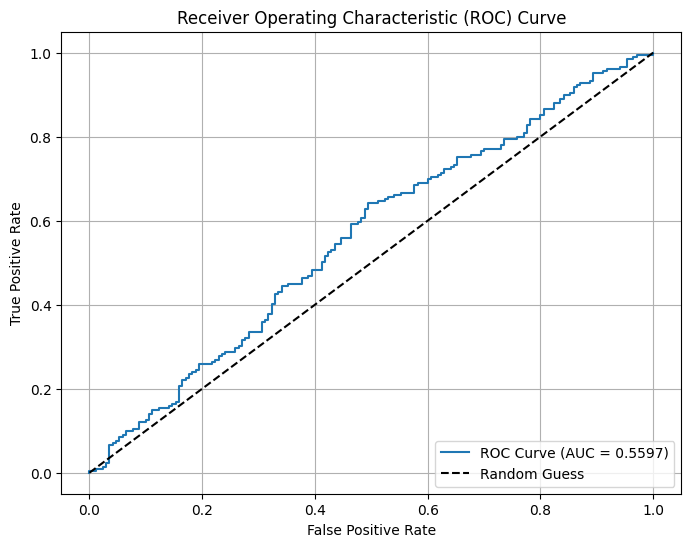

ROC AUC Score: 0.5597


In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(matchups_df: pd.DataFrame) -> None:
    """
    Plots the ROC Curve and prints the AUC.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_win_prob' and 'res' columns.
    """
    # Convert actual results to binary outcomes for home wins
    y_true = matchups_df['res'].apply(lambda x: 1 if x == 'h' else 0)
    y_prob = matchups_df['home_win_prob']
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f"ROC AUC Score: {auc_score:.4f}")

# Example usage:
plot_roc_curve(aggregated_matchups)

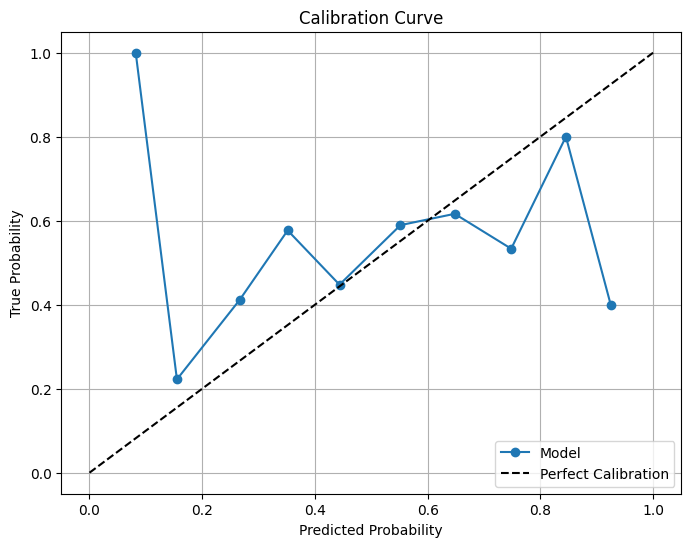

In [74]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(matchups_df: pd.DataFrame, n_bins: int = 10) -> None:
    """
    Plots the calibration curve of the predicted probabilities.
    
    Args:
        matchups_df (pd.DataFrame): DataFrame containing 'home_win_prob' and 'res' columns.
        n_bins (int): Number of bins to discretize the [0, 1] interval.
    """
    # Convert actual results to binary outcomes for home wins
    y_true = matchups_df['res'].apply(lambda x: 1 if x == 'h' else 0)
    y_prob = matchups_df['home_win_prob']
    
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_calibration_curve(aggregated_matchups)